In [3]:
import sys
sys.path.append('/scratch/nf33/sc5932/hk25-AusNode-TConvZones/functions')

from SC_function import get_nn_lon_lat_index

import xarray as xr
import healpy as hp
import easygems.healpix as egh
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from dask.diagnostics import ProgressBar


## read model data

In [4]:
zoom = '7'
file_uk = '/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT1H.z' + zoom + '.zarr'
file_germany = "/g/data/qx55/germany_node/d3hp003.zarr/P1D_point_z" + zoom + "_atm.zarr"

time_start = "2020-03-01"
time_end = "2021-02-28"

# Uk node
ds_uk = xr.open_zarr(file_uk).pr*3600
ds_uk_daily = ds_uk.resample(time="1D").sum()
mean_uk = ds_uk_daily.sel(time=slice(time_start, time_end)).mean(dim="time")

# Germany node
ds_germany = xr.open_zarr(file_germany).pr*86400
mean_germany = ds_germany.sel(time=slice(time_start, time_end)).mean(dim="time")

# plot by healpix
# egh.healpix_show(mean_germany, cmap="Blues", dpi=72,vmin=0,vmax=10)


In [11]:
ds_uk [1]

<xarray.DataArray 'pr' (cell: 196608)> Size: 786kB
dask.array<getitem, shape=(196608,), dtype=float32, chunksize=(16384,), chunktype=numpy.ndarray>
Coordinates:
  * cell     (cell) int64 2MB 0 1 2 3 4 5 ... 196603 196604 196605 196606 196607
    crs      float64 8B ...
    time     datetime64[ns] 8B 2020-01-20T01:00:00

## ERA5

In [3]:
files = [
    '/g/data/rt52/era5/single-levels/reanalysis/tp/2020/*.nc',
    '/g/data/rt52/era5/single-levels/reanalysis/tp/2021/*.nc'
]
ds_era5 = xr.concat([xr.open_mfdataset(f, combine='nested', concat_dim='time') for f in files], dim='time')

ds_era5_daily = ds_era5.tp.resample(time="1D").sum()
mean_era5 = ds_era5_daily.sel(time=slice(time_start,time_end)).mean(dim="time") * 1000  #original unit is meter

In [ ]:
with ProgressBar():
    mean_era5_loaded = mean_era5.load()
# mean_era5.to_netcdf('/scratch/nf33/sc5932/Data/mean_era5.nc')


[########################################] | 100% Completed | 227.06 s


## regrid the model to era5

In [10]:
# longitudes and latitudes for the ERA5 grid
mean_era5_loaded = xr.open_dataset('/scratch/nf33/sc5932/Data/mean_era5.nc').tp

lon = mean_era5_loaded['longitude'].values
lat = mean_era5_loaded['latitude'].values

### UM regridded to era5
this_nside = hp.get_nside(mean_uk)
cells = get_nn_lon_lat_index(this_nside, lon, lat) 
mean_uk_regrid = mean_uk.isel(cell = cells)

### ICON regridded to era5
this_nside = hp.get_nside(mean_germany)
cells = get_nn_lon_lat_index(this_nside, lon, lat) 
mean_germany_regrid = mean_germany.isel(cell = cells)

In [12]:

mean_uk_aligned = mean_uk_regrid.rename({'lat': 'latitude', 'lon': 'longitude'})

# Drop unrelated coords if needed (optional but cleaner)
mean_uk_aligned = mean_uk_aligned.drop_vars(['cell', 'crs'], errors='ignore')

mean_germany_aligned = mean_germany_regrid.rename({'lat': 'latitude', 'lon': 'longitude'})

# Drop unrelated coords if needed (optional but cleaner)
mean_germany_aligned = mean_germany_aligned.drop_vars(['cell', 'crs'], errors='ignore')



In [13]:
mean_uk_aligned.to_netcdf('/scratch/nf33/sc5932/Data/mean_uk_aligned.nc')
mean_germany_aligned.to_netcdf('/scratch/nf33/sc5932/Data/mean_germany_aligned.nc')


## plot

In [7]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

mean_all = [
    mean_era5_loaded,
    mean_uk_regrid - mean_era5_loaded,
    mean_germany_regrid - mean_era5_loaded
]

# Define projection
projection = ccrs.PlateCarree(central_longitude=205)

# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10), subplot_kw={'projection': projection})
axes = axes.flatten()

# # Plot ERA5 mean precipitation in axes[0]
# vmin_main, vmax_main = 0, 10  # Adjust if needed
# mappable_main = mean_all[0].plot(
#     ax=axes[0],
#     cmap='Blues',
#     vmin=vmin_main,
#     vmax=vmax_main,
#     transform=ccrs.PlateCarree(),
#     add_colorbar=False
# )
# axes[0].coastlines()
# axes[0].set_title('ERA5 Mean Precipitation')

# # Hide axes[1] and use it for the colorbar
# axes[1].axis('off')
# cbar_main = fig.colorbar(mappable_main, ax=axes[1], orientation='vertical', fraction=0.8)
# cbar_main.set_label('Precipitation (mm)')

# # Set common color scale for difference plots
vmin_diff, vmax_diff = -5, 5  # Adjust if needed

# # Plot difference: UK - ERA5 in axes[2]
# mappable_diff = mean_all[1].plot(
#     ax=axes[2],
#     cmap='RdBu',
#     vmin=vmin_diff,
#     vmax=vmax_diff,
#     transform=ccrs.PlateCarree(),
#     add_colorbar=False
# )
# axes[2].coastlines()
# axes[2].set_title('UK - ERA5 Difference')

# Plot difference: Germany - ERA5 in axes[3]
mean_all[2].plot(
    ax=axes[3],
    cmap='RdBu',
    vmin=vmin_diff,
    vmax=vmax_diff,
    transform=ccrs.PlateCarree(),
    add_colorbar=False
)
axes[3].coastlines()
axes[3].set_title('Germany - ERA5 Difference')

# Add colorbar for difference plots in axes[1] as well
cbar_diff = fig.colorbar(mappable_diff, ax=axes[1], orientation='horizontal', fraction=0.8, pad=0.05)
cbar_diff.set_label('Difference (mm)')

plt.tight_layout()
plt.show()





: 

## plot

In [ ]:

projection = ccrs.PlateCarree(central_longitude=205)
fig, ax = plt.subplots(figsize=(10, 5),subplot_kw = {"projection": projection})
mean_uk_regrid.plot(cmap = 'Blues', vmin = 0, vmax = 10,transform = ccrs.PlateCarree())
ax.coastlines()
ax.set_title('UM Daily Mean Precipitation from Feb 2020 to March 2021')

ImportError: generic_type: type "RendererAgg" is already registered!

Text(0.5, 1.0, ' ICON Daily Mean Precipitation from Feb 2020 to March 2021')

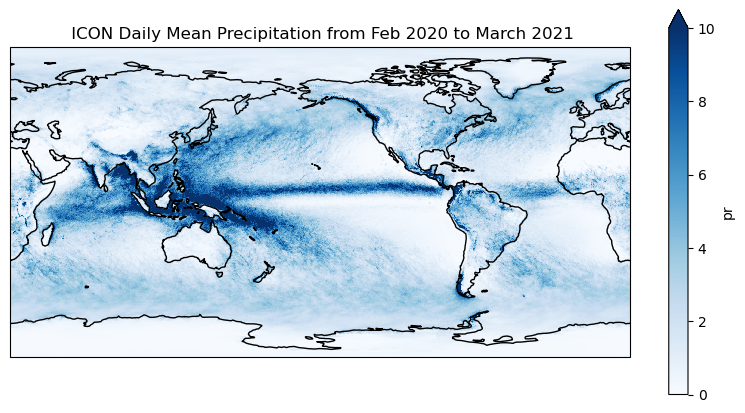

In [68]:

projection = ccrs.PlateCarree(central_longitude=205)

fig, ax = plt.subplots(figsize=(10, 5),subplot_kw = {"projection": projection})
mean_germany_regrid.plot(cmap = 'Blues', vmin = 0, vmax = 10,transform = ccrs.PlateCarree())
ax.coastlines()
ax.set_title(' ICON Daily Mean Precipitation from Feb 2020 to March 2021')